# Appendix

## Data Acquisition/Pre-Processing

In [1]:
# Import libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import time
import warnings
from datetime import datetime 
from sklearn import preprocessing
init_notebook_mode(connected=True) 
import multiprocessing
from multiprocessing.pool import ThreadPool
import timeit
warnings.filterwarnings('ignore')

In [2]:
# Data pre-processing 
df = pd.read_csv("airlines_delay.csv", sep = ",") # read dataset
df.info() # check data 

# Do label encoding for the categorical variables
AirlineUnique = df.Airline.unique() # get unique levels
AirportFromUnique = df.AirportFrom.unique()
AirportToUnique = df.AirportFrom.unique()

lenAirlineUnique = len(df.Airline.unique()) # length of list
lenAirportFromUnique = len(df.AirportFrom.unique())
lenAirportToUnique = len(df.AirportTo.unique())

Airlinelst = list(range(0,lenAirlineUnique)) # create list of numbers
df['NumAirline'] = df['Airline'] # label encode
df['NumAirline'].replace(AirlineUnique, Airlinelst , inplace=True)   

AirportFromlst = list(range(0,lenAirportFromUnique))
df['NumAirportFrom'] = df['AirportFrom']
df['NumAirportFrom'].replace(AirportFromUnique, AirportFromlst , inplace=True)

AirportTolst = list(range(0,lenAirportToUnique))
df['NumAirportTo'] = df['AirportTo']
df['NumAirportTo'].replace(AirportToUnique, AirportTolst , inplace=True) 

df = df.sample(n=10000) # Get reduced dataset

X = df[['Length','NumAirline', 'NumAirportFrom','NumAirportTo','DayOfWeek']] # get X dataframe
y = df['Class'] # get response

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539382 entries, 0 to 539381
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Flight       539382 non-null  float64
 1   Time         539382 non-null  float64
 2   Length       539382 non-null  float64
 3   Airline      539382 non-null  object 
 4   AirportFrom  539382 non-null  object 
 5   AirportTo    539382 non-null  object 
 6   DayOfWeek    539382 non-null  int64  
 7   Class        539382 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 32.9+ MB


## Created Simulated Dataset

In [3]:
# Create Simulated Dataset
from sklearn.datasets import make_classification

# Get simulated Data
X_simulated_small, y_simulated_small = make_classification(
    n_samples=300,
    n_features=6, 
    n_classes=2, 
    random_state=1
)

X_simulated_large, y_simulated_large = make_classification(
    n_samples=15000,
    n_features=6, 
    n_classes=2, 
    random_state=1
)

## Exploratory Data analysis

In [4]:
# %delays by airline
flights_per_airline = df.groupby('Airline').agg({'Class':'count'}) # number of flights by airline
delays_by_airline =df.groupby('Airline').agg({'Class':'sum'}) # summing up delays by each airline
flights_per_airline['delays'] = delays_by_airline['Class'] # total flights and delays per airline
flights_per_airline.rename(columns={"Class":"flights"}) # renaming col
flights_per_airline['%_delays'] = flights_per_airline['delays']/flights_per_airline.iloc[:,0] # % of delays per airline
flights_per_airline = flights_per_airline.reset_index() # resetting index
flights_per_airline

,Airline,Class,delays,%_delays
0,9E,404,163,0.403465
1,AA,819,304,0.371184
2,AS,217,75,0.345622
3,B6,353,176,0.498584
4,CO,388,213,0.548969
5,DL,1205,545,0.452282
6,EV,556,230,0.413669
7,F9,122,50,0.409836
8,FL,381,122,0.320210
9,HA,88,32,0.363636


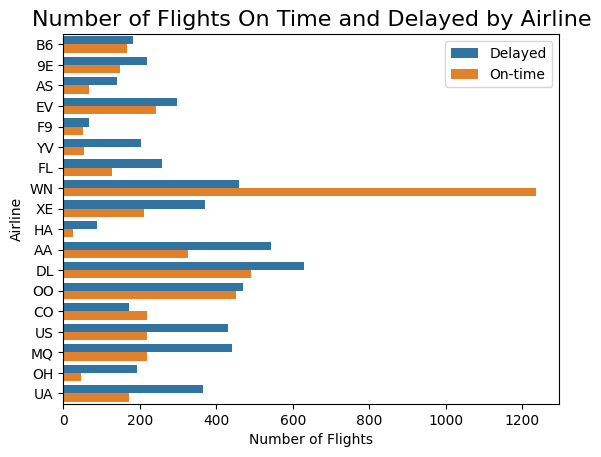

In [5]:
# Number of Flights On time and Delayed
plt.title('Number of Flights On Time and Delayed by Airline', fontsize=16)
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="Airline", hue='Class', data=df) # getting horizontal boxplots
# formatting legend
legend= plt.legend()
legend.get_texts()[1].set_text('On-time') 
legend.get_texts()[0].set_text('Delayed')
plt.xlabel('Number of Flights')
plt.show()

Text(0.5, 1.0, 'Percent of Delays by Airline')

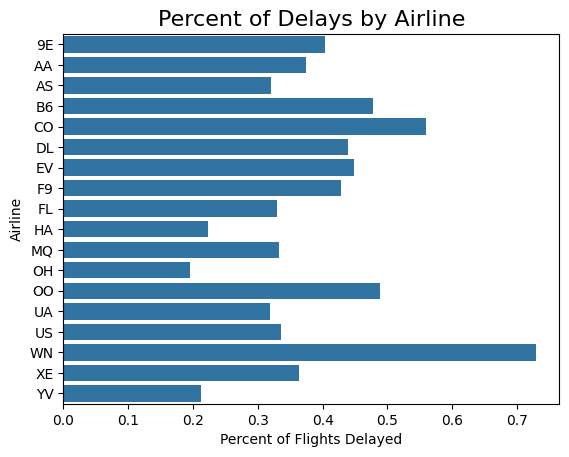

In [6]:
# Percent Delays by Airline
sns.barplot(y= 'Airline', x= '%_delays', data=flights_per_airline, orient='h', color='C0') # plotting percentage of flights delayed by airline
plt.xlabel('Percent of Flights Delayed')
plt.title('Percent of Delays by Airline', fontsize=16)

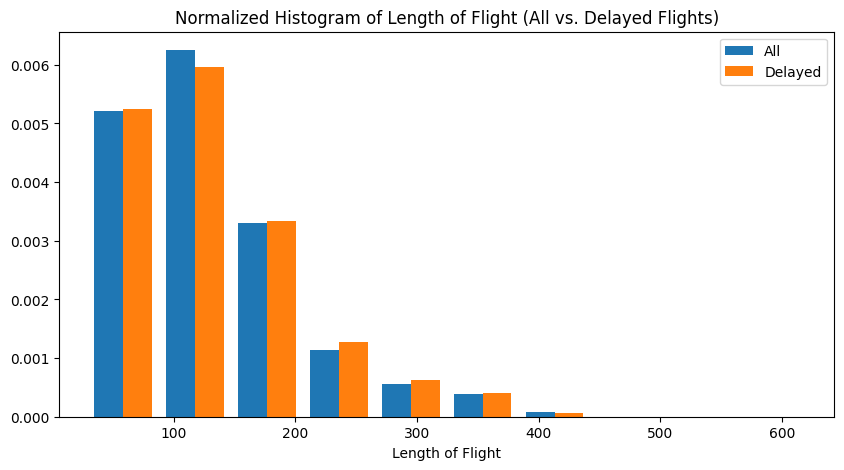

In [7]:
delayed = df[df['Class']==1] # subset df of only delayed flights
fig, ax = plt.subplots(figsize = (10,5))
ax.hist([df['Length'], delayed['Length']], label=['All', 'Delayed'], density = True) # histogram of lengths of flights for delayed vs. on-time flights
ax.set_xlabel('Length of Flight')
ax.set_title('Normalized Histogram of Length of Flight (All vs. Delayed Flights)')
plt.legend()
plt.show()

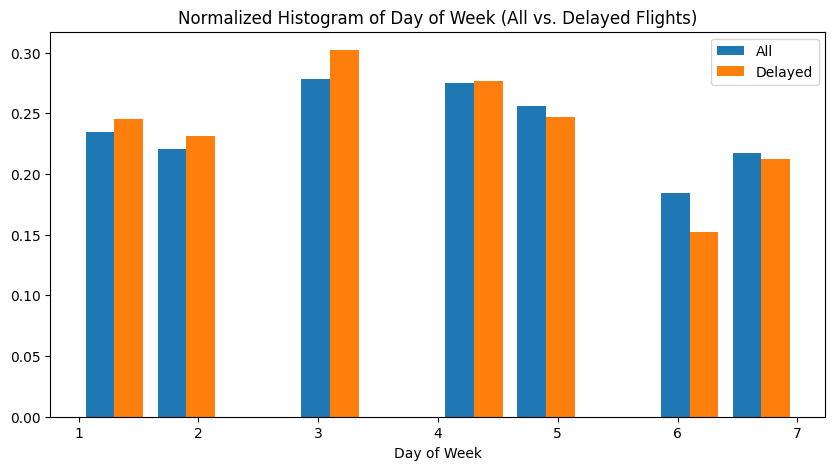

In [8]:
delayed = df[df['Class']==1] # subset df of only delayed flights
fig, ax = plt.subplots(figsize = (10,5))
ax.hist([df['DayOfWeek'], delayed['DayOfWeek']], label=['All', 'Delayed'], density=True) # histogram of lengths of flights for delayed vs. on-time flights
ax.set_xlabel('Day of Week')
ax.set_title('Normalized Histogram of Day of Week (All vs. Delayed Flights)')
plt.legend()
plt.show()

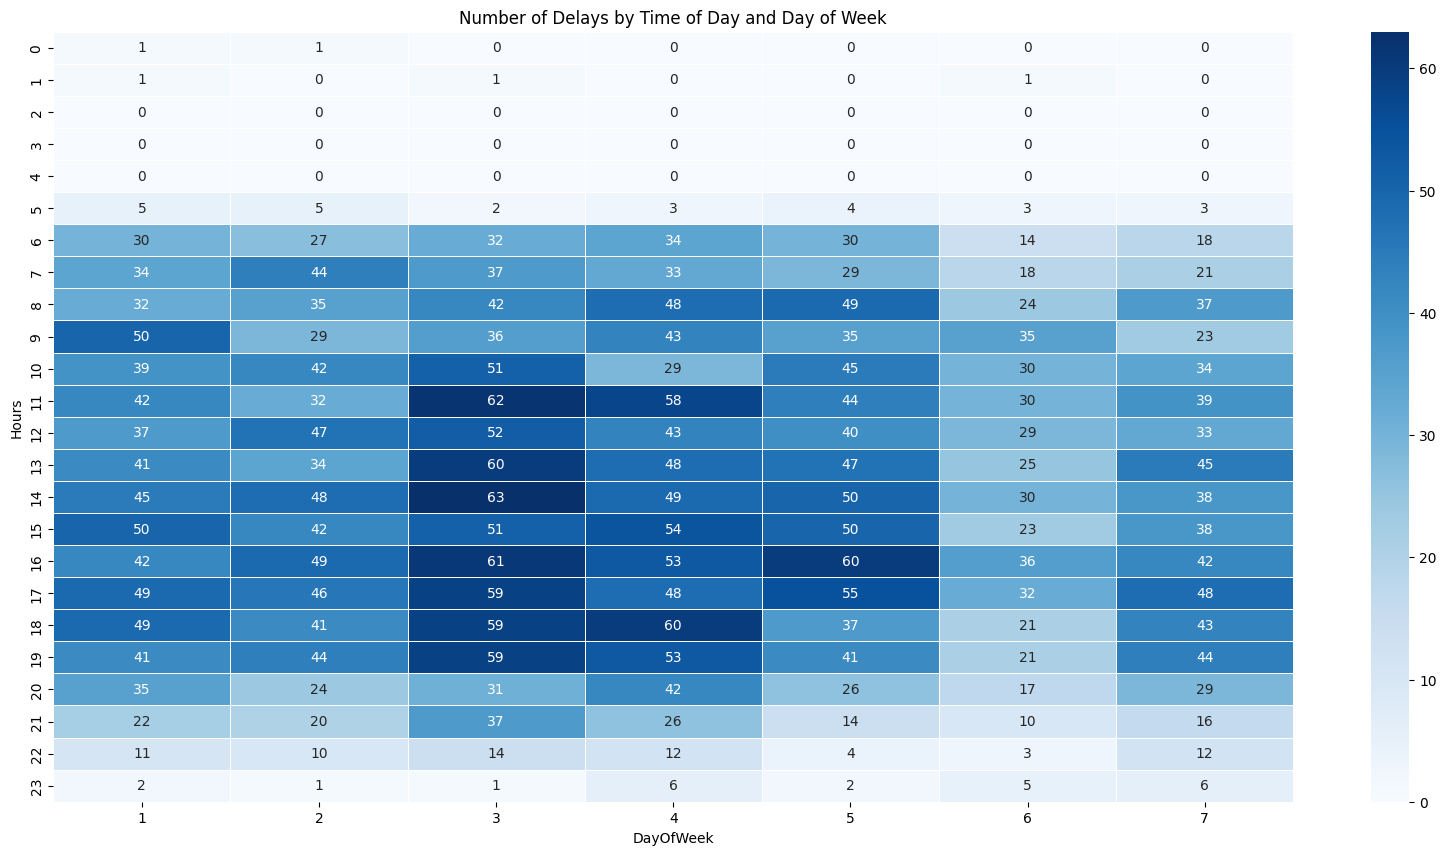

In [9]:
# Number of delays by day of week and time of the day (DC)
time_bins = [0]
initial_time = 0
for i in range(24): # for 24 hours in day
    initial_time += 60 # every 180 minutes, there's a new hour 
    time_bins.append(initial_time) # storing all minute counts of the day
    
# Labels for Hours of the Day
time_labels = ['0','1','2','3','4','5','6','7','8','9', '10', '11',
         '12','13','14','15','16','17','18','19','20','21', '22', '23']

df['Hours'] = pd.cut(x = df['Time'], bins = time_bins, labels = time_labels, right = False, include_lowest = True) # Adding Hours of the Day to dataframe 

sub_df = df[df.Class != 0] # only keeping flights that were delayed
sub_df = sub_df.groupby(['DayOfWeek', 'Hours','Class']) # subsetting data
num_delays = sub_df.Class.sum() # Getting # of delays by day of week and time of day
sub_df = num_delays.reset_index(name = 'Delays') # resetting index
sub_df = sub_df.drop(['Class'], axis = 1).reset_index() # dropping class col
sub_df = sub_df.pivot_table(values='Delays', index='Hours', columns='DayOfWeek', aggfunc='sum') # pivoting data frame

fig, ax = plt.subplots(figsize=(20, 10)) # set figure size
sns.heatmap(sub_df, annot=True, linewidth=.5, cmap="Blues",ax = ax) # create heat plot
plt.title('Number of Delays by Time of Day and Day of Week')
plt.show()

# Naive Bayes

In [10]:
def max_class(x, prior_list, mean_list, variance_list):
    ''' This function computes the likelihood for each x observation that it receives given each class. It multiplies 
    this likelihood by the prior information (probability of the class), and then divides this by the marginal probability
    of the x observation. The function then returns the class that yields the maximum posterior.'''
    
    likelihoods = [] # storing likelihoods
    post = [] # storing posteriors
    for index in range(2): # for the two classes
        likelihood_num = np.exp((-1/2)*((x-mean_list[index])**2) / (2 * variance_list[index])) # calculating likelihood numerator
        likelihood_den = np.sqrt(2 * np.pi * variance_list[index]) # calculating likelihood denominator
        likelihoods.append(likelihood_num/likelihood_den) # storing all likelihods
    post.append(np.log(prior_list[0]) + np.sum(np.log(likelihoods[0]))) # getting posterior for 1st class
    post.append(np.log(prior_list[1]) + np.sum(np.log(likelihoods[1]))) # getting posterior for 2nd class
    return(np.argmax(post)) # getting class with max posterior


import multiprocessing
from multiprocessing.pool import ThreadPool
import timeit

def Parallel_NB(X_train, X_test, y_train):
    ''' This function takes in training and X testing data and references the max_class function to
    compute the posterior probability for both classes and get the class with the max posterior. It uses parallel
    computing via multiprocessing to parallely compute the conditional likelihood probabilities for each x observation.
    This function returns the output from the max_class function, which is the class that yields the maximum posterior.'''
    
    # Get mean, variance & prior
    n = len(X_train) # number of observations
    m = len(X_train.columns) # number of predictors
    class_types = y_train.unique() # all classes
    total_classes = 2 # 2 classes total
    prior_list = np.zeros(total_classes, dtype = float) # initializing prior
    mean_list = np.zeros((total_classes, m), dtype = float) # initializing mean
    variance_list = np.zeros((total_classes, m), dtype = float) # initializing variance
    for index in range(2): # classes are 0,1 
            sub_df = X_train[y_train == index]  # only keeping observations with first class               
            prior_list[index] = len(sub_df) / n # all observations for one class
            mean_list[index, :] = sub_df.mean(axis=0) # getting means of each observation
            variance_list[index, :] = sub_df.var(axis=0)  # getting variances of each observation
    X_testing = X_test.to_numpy() # converting X_test data frame to array
    Xis = [] # storing each X observation from X_test
    #X_testing = X_testing.to_numpy()
    for Xi in X_testing:
        Xis.append(Xi.tolist()) # getting list of all X observations
    pool = ThreadPool(5) # creating pool
    y_predicted_parallel = [pool.apply(max_class, args=([Xi], prior_list, mean_list, variance_list)) for Xi in Xis] # parallely computing the posterior probability + getting best class for each x observation 
    return(y_predicted_parallel) # returning the indexes that yielded the highest posterior probabilityß

def test_accuracy(true_values, predicted_values):
    '''This function returns the accuracy % between the actual and predicted values'''
    correct_id = 0
    for i in range(len(true_values)):
        if true_values[i] == predicted_values[i]:
            correct_id += 1
    return correct_id / float(len(true_values))

In [11]:
# Simulated Study Naive Bayes (small data)
bayes_start = time.time() # start time
accuracy_list_bayes = list()
for i in range(0, 10):
    X_train, X_test, y_train, y_test = train_test_split(X_simulated_small, y_simulated_small, test_size=0.2, random_state=i)
    X_train = pd.DataFrame(X_train) 
    X_test = pd.DataFrame(X_test)
    y_train = pd.Series(y_train)
    predY = Parallel_NB(X_train, X_test, y_train)
    bayes_accuracy = test_accuracy(y_test, predY)
    accuracy_list_bayes.append(bayes_accuracy)

avg_accuracy_bayes = sum(accuracy_list_bayes)/len(accuracy_list_bayes)

bayes_end = time.time() # end time
bayes_speed = bayes_end - bayes_start # get speed
print(f'Prediction accuracy of model: {avg_accuracy_bayes}')
print(f'Training time for Naive Bayes: {bayes_speed}')

Prediction accuracy of model: 0.9133333333333334
Training time for Naive Bayes: 0.11333608627319336


In [12]:
# Simulated Study Naive Bayes (large data)
bayes_start = time.time() # start time
accuracy_list_bayes = list()
for i in range(0, 10):
    X_train, X_test, y_train, y_test = train_test_split(X_simulated_large, y_simulated_large, test_size=0.2, random_state=i)
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    y_train = pd.Series(y_train)
    predY = Parallel_NB(X_train, X_test, y_train)
    bayes_accuracy = test_accuracy(y_test, predY)
    accuracy_list_bayes.append(bayes_accuracy)

avg_accuracy_bayes = sum(accuracy_list_bayes)/len(accuracy_list_bayes)

bayes_end = time.time() # end time
bayes_speed = bayes_end - bayes_start # get speed
print(f'Prediction accuracy of model: {avg_accuracy_bayes}')
print(f'Training time for Naive Bayes: {bayes_speed}')

Prediction accuracy of model: 0.8930000000000001
Training time for Naive Bayes: 1.9431099891662598


In [13]:
# Real data study for Naive Bayes
naive_beg = time.time() # start time
accurage_metric_naive = list()
for i in range(0, 10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i, shuffle = True)
    y_predicted_parallel = Parallel_NB(X_train, X_test, y_train) # getting predicted y observations
    y_test = y_test.to_numpy() # convert to numpy
    naive_accuracy = test_accuracy(y_test, y_predicted_parallel)
    accurage_metric_naive.append(naive_accuracy)
avg_accuracy_naive= sum(accurage_metric_naive)/len(accurage_metric_naive)
naive_end = time.time() # end time
naive_speed = naive_end - naive_beg # time elapsed

print(f'Prediction accuracy of model: {avg_accuracy_naive}')
print(f'Training time for Naive Bayes: {naive_speed}')

Prediction accuracy of model: 0.5672499999999999
Training time for Naive Bayes: 1.2618098258972168


### Standardize data

In [10]:
from sklearn.preprocessing import StandardScaler # standardize data
X_std = StandardScaler().fit_transform(X)
X_std = X_std.to_numpy()
y = y.to_numpy()

## Logistic Regression

### Implementing w/ Gradient Ascent

In [15]:
class logregwMLE:
    '''Reference: https://vasugupta2000.medium.com/implementation-of-grad-ascent-using-logistic-regression-7f5343877c21
    Author: Vasugupta '''
    
    def __init__(self, lr=0.01, numiterations=100):
        '''Initialize lr and numiterations variables. 'lr' is the learning rate, 'numiterations' is the max number of iterations.'''
        self.lr  = lr # initialize learning rate & number of iterations 
        self.numiterations = numiterations
        self.lls = []
        self.eps = 1e-10 # log(0) does not exist so set epsilon=1e-10 to prevent log(0) error

    def sig(self, z):
        '''Computes sigmoid function: sigmoid(z)=1/(1+e^(-z)), where z=transpose(theta)*x'''       
        sigmoidz = (1/(1+np.exp(-z)))   
        return sigmoidz
    
    def logL(self, ycorrect, predY):
        '''Computes the maximum log-likelihood function. ycorrect is the true y values, predY are the predicted y values. '''
        predY = np.maximum(np.full(predY.shape, self.eps), np.minimum(np.full(predY.shape, 1-self.eps), predY)) # make sure that there are no 0 or 1 values to prevent log error 
        ll = (ycorrect*np.log(predY)+(1-ycorrect)*np.log(1-predY)) # compute likelihood function 
        llavg = ll.mean() # mean of likelihood 
        return llavg
    
    def fit(self, X, y):
        '''fit function to later fit X_train and y_train to the logistic regression model'''
        numex = X.shape[0] # examples
        feats = X.shape[1] # features
        self.wghs = np.zeros((X.shape[1])) # choose weight values 
          
        # apply gradient ascent
        for i in range(self.numiterations):
            z  = X @ self.wghs
            predY = self.sig(z) # compute sigmoid(z) to find probability values
            grad = np.mean((y-predY)*X.T, axis=1) # compute gradient 
            self.wghs +=  self.lr*grad # update the weights with respect to the gradient 
            # compute log-likelihood function 
            ll = self.logL(y,predY)
            self.lls.append(ll) # add to the list 
        
    def predprob(self,X):
        '''Returns the prediction probabilities (0 or 1) for X'''
        if self.wghs is None:
            raise Exception('Need to fit the model') # make sure that the model has been fitted             
        z = X @ self.wghs # compute z using the formula z = transpose(theta)*X = weights*X
        probs = self.sig(z) # 0 or 1 probabilities 
        return probs
    
    def predict(self, X, threshold=0.5):
        '''Function to classify X values based given threshold=0.5. Threshold sets x value to 0 if not equal to 1'''        
        bpredY = np.array(list(map(lambda x: 1 if x>threshold else 0, self.predprob(X)))) # binary predictions, 0 or 1
        return bpredY

In [16]:
# Simulated Study Gradient Ascent (small data)
gamle_start = time.time() # start time
model = logregwMLE()
accuracy_list_gda = list()
for i in range(0, 10):
    X_train, X_test, y_train, y_test = train_test_split(X_simulated_small, y_simulated_small, test_size=0.2, random_state=i)
    model.fit(X_train,y_train)
    predY = model.predict(X_test)
    gamle_accuracy = test_accuracy(y_test, predY)
    accuracy_list_gda.append(gamle_accuracy)

avg_accuracy_gda = sum(accuracy_list_gda)/len(accuracy_list_gda)

gamle_end = time.time() # end time
gamle_speed = gamle_end - gamle_start # get speed
print(f'Prediction accuracy of model: {avg_accuracy_gda}')
print(f'Training time for Logistic Regression with Gradient Ascent: {gamle_speed}')

Prediction accuracy of model: 0.9133333333333334
Training time for Logistic Regression with Gradient Ascent: 0.05619406700134277


In [17]:
# Simulated Study Gradient Ascent (large data)
gamle_start = time.time() # start time
model = logregwMLE()
accuracy_list_gda = list()
for i in range(0, 10):
    X_train, X_test, y_train, y_test = train_test_split(X_simulated_large, y_simulated_large, test_size=0.2, random_state=i)
    model.fit(X_train,y_train)
    predY = model.predict(X_test)
    gamle_accuracy = test_accuracy(y_test, predY)
    accuracy_list_gda.append(gamle_accuracy)

avg_accuracy_gda = sum(accuracy_list_gda)/len(accuracy_list_gda)

gamle_end = time.time() # end time
gamle_speed = gamle_end - gamle_start # get speed
print(f'Prediction accuracy of model: {avg_accuracy_gda}')
print(f'Training time for Logistic Regression with Gradient Ascent: {gamle_speed}')

Prediction accuracy of model: 0.8605333333333333
Training time for Logistic Regression with Gradient Ascent: 0.6181886196136475


In [18]:
# Real data study
gamle_start = time.time() # start time
model = logregwMLE()
accuracy_list_gda = list()
for i in range(0, 10):
    X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=i)
    model.fit(X_train,y_train)
    predY = model.predict(X_test)
    gamle_accuracy = test_accuracy(y_test, predY)
    accuracy_list_gda.append(gamle_accuracy)

avg_accuracy_gda = sum(accuracy_list_gda)/len(accuracy_list_gda)

gamle_end = time.time() # end time
gamle_speed = gamle_end - gamle_start # get speed
print(f'Prediction accuracy of model: {avg_accuracy_gda}')
print(f'Training time for Logistic Regression with Gradient Ascent: {gamle_speed}')

Prediction accuracy of model: 0.5589999999999999
Training time for Logistic Regression with Gradient Ascent: 0.46085023880004883


### Implementation with Gradient Descent 

In [19]:
import math

In [22]:
# define sigmoid function
def sig(X, weight):
    z = X @ weight
    return 1 / (1 + np.exp(-z))

# gradient descent function
def graddescent(X, g, y):
    gd = (X.T @ (g - y)) / y.shape[0]
    return gd

# function to update weight loss 
def new_weightloss(weight, lr, grad):
    return (weight - lr * grad)

In [23]:
def generateX(X):
    """This function takes in the predictor variables and adds a row of 1's which corresponds to x_0"""    
    vectorX = np.c_[np.ones((len(X), 1)), X]
    return vectorX

def get_initial_vec(X):
    """This function generate an initial value of vector θ from the original independent variables matrix"""
    initial_vec = np.random.randn(len(X[0])+1, 1)
    return initial_vec

def sigmoid_function(X):
    """ This function calculates the sigmoid value of the inputs"""
    sigmoid_val = 1/(1+math.e**(-X))
    return sigmoid_val

def Logistic_Fit(X,y,learningrate, iterations):
    """This function creates a logistic model function for our dataset. X is the independent variables, y are dependent 
    variables matrix learningrate is learningrate of Gradient Descent, iterations is the number of iterations. This 
    function will return guess vector.
    """
    y_new = np.reshape(y, (len(y), 1))   
    cost_lst = []
    vectorX = generateX(X)
    theta = get_initial_vec(X)
    m = len(X)
    for i in range(iterations):
        gradients = 2/m * vectorX.T.dot(sigmoid_function(vectorX.dot(theta)) - y_new)
        theta = theta - learningrate * gradients
    return theta

def column(matrix, i):
    """ This function will return all the values in a specific columns"""
    return [row[i] for row in matrix]


def accuracy_metric(X,y,learningrate, iteration,X_test, y_test):
    """ Returning the accuracy score for a training model"""
    
    fit_model = Logistic_Fit(X,y,learningrate, iteration)
    
    line = fit_model[0]
    
    for i in range(1,len(fit_model)):
        line = line + fit_model[i]*column(X_test,i-1)
    logistic_function = sigmoid_function(line)
    for i in range(len(logistic_function)):
        if logistic_function[i] >= 0.5:
            logistic_function[i] = 1
        else:
            logistic_function[i] = 0
    
    last1 = np.concatenate((logistic_function.reshape(len(logistic_function),1), y_test.reshape(len(y_test),1)),1)
    
    count = 0
    for i in range(len(y_test)):
        if last1[i][0] == last1[i][1]:
            count = count+1
    acc = count/(len(y_test))
    return acc

In [25]:
# real dataset
gamle_start = time.time() # start time
accuracy_list_gdd = list()
for i in range(0, 10):
    X_train, X_test, y_train, y_test = train_test_split(X_simulated_small, y_simulated_small, test_size=0.2, random_state=i)
    accuracy_val = accuracy_metric(X_train,y_train, .1, 100,X_test, y_test)
    accuracy_list_gdd.append(accuracy_val)
avg_accuracy_gda = sum(accuracy_list_gdd)/len(accuracy_list_gdd)

gamle_end = time.time() # end time
gamle_speed = gamle_end - gamle_start # get speed
print(f'Prediction accuracy of model: {avg_accuracy_gda}')
print(f'Training time for Logisitc Regression using Gradient Ascent: {gamle_speed}')

Prediction accuracy of model: 0.9116666666666667
Training time for Logisitc Regression using Gradient Ascent: 0.02618408203125


In [26]:
# real dataset
gamle_start = time.time() # start time
accuracy_list_gdd = list()
for i in range(0, 10):
    X_train, X_test, y_train, y_test = train_test_split(X_simulated_large, y_simulated_large, test_size=0.2, random_state=i)
    accuracy_val = accuracy_metric(X_train,y_train, .1, 100,X_test, y_test)
    accuracy_list_gdd.append(accuracy_val)
avg_accuracy_gda = sum(accuracy_list_gdd)/len(accuracy_list_gdd)

gamle_end = time.time() # end time
gamle_speed = gamle_end - gamle_start # get speed
print(f'Prediction accuracy of model: {avg_accuracy_gda}')
print(f'Training time for Logisitc Regression using Gradient Ascent: {gamle_speed}')

Prediction accuracy of model: 0.8977333333333334
Training time for Logisitc Regression using Gradient Ascent: 0.5909037590026855


In [27]:
# real dataset
gamle_start = time.time() # start time
accuracy_list_gdd = list()
for i in range(0, 10):
    X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=i)
    accuracy_val = accuracy_metric(X_train,y_train, .1, 100,X_test, y_test)
    accuracy_list_gdd.append(accuracy_val)
avg_accuracy_gda = sum(accuracy_list_gdd)/len(accuracy_list_gdd)

gamle_end = time.time() # end time
gamle_speed = gamle_end - gamle_start # get speed
print(f'Prediction accuracy of model: {avg_accuracy_gda}')
print(f'Training time for Logisitc Regression using Gradient Ascent: {gamle_speed}')

Prediction accuracy of model: 0.5492
Training time for Logisitc Regression using Gradient Ascent: 0.3654489517211914


### K-NN Implementation

Minimum error:- 0.3985 at K = 18


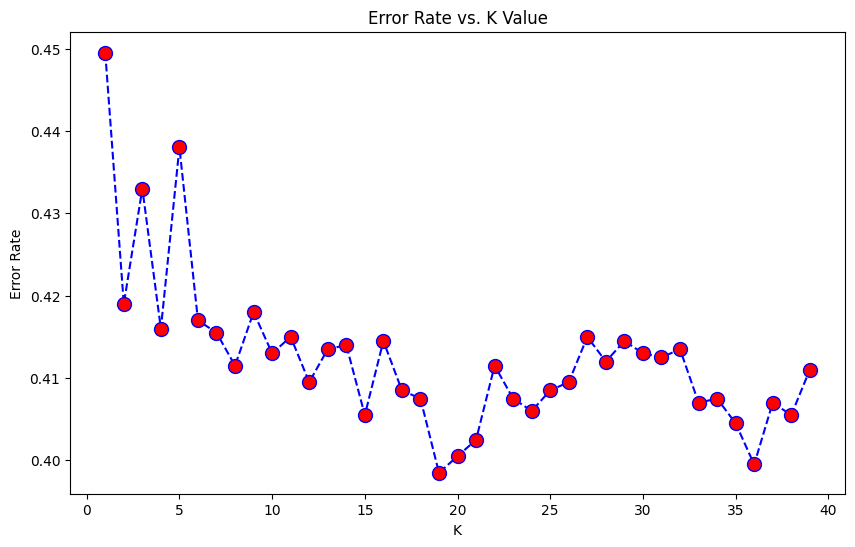

In [29]:
# Get K
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=1, shuffle = True)
error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [30]:
# Example of calculating Euclidean distance :: from source no changes
# calculate the Euclidean distance between two vectors
from math import sqrt

def euclidean(row1, row2):
    '''This function returns the euclidean distance between two rows'''
    dist = 0.0
    for i in range(len(row1)-1):
        dist += (row1[i] - row2[i])**2
    return sqrt(dist)

def get_neighbors(train, test_row, num_neighbors): # get neighbors
    '''This function returns the rows frow the training data based on the smallest distances'''
    i = 0
    index_list = list()
    distances = list()
    for train_row in train:
        dist = euclidean(test_row, train_row)
        distances.append((train_row, dist, i))
        i += 1
        distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    for i in range(num_neighbors):
        neighbors.append((distances[i][0],distances[i][2]))
    return neighbors

def predict_classification(x_train, y_train, test_row, num_neighbors):
    neighbors = get_neighbors(x_train, test_row, num_neighbors)
    index_list = list()
    for i in neighbors:
        index_list.append(i[1])
    output_values = y_train[index_list].tolist()
    prediction = max(set(output_values), key=output_values.count)
    return prediction

In [31]:
# Simulated Data - small
from joblib import Parallel, delayed
import multiprocessing
knn1_start = time.time() # start time 
accurage_metric_list_1 = list()
for i in range(0, 10):
    X_train, X_test, y_train, y_test = train_test_split(X_simulated_small, y_simulated_small, test_size=0.2, random_state=i)
    inputs = list(range(len(X_test)))
    def multi_run(t):
        return predict_classification(X_train, y_train, X_test[t], 25)
    num_cores = multiprocessing.cpu_count()
    results = Parallel(n_jobs=num_cores)(delayed(multi_run)(i) for i in inputs)
    accurage_metric_list_1.append(test_accuracy(y_test, results))
avg_accuracy_1 = sum(accurage_metric_list_1)/len(accurage_metric_list_1)

knn1_end = time.time() # end time
knn1_speed = knn1_end - knn1_start # time elapsed
print('K-NN runtime:', knn1_speed, 'seconds')
print('K-NN accuracy:', avg_accuracy_1, '%')

K-NN runtime: 0.6185421943664551 seconds
K-NN accuracy: 0.915 %


In [32]:
# Simulated Data - Large 
knn1_start = time.time() # start time 
accurage_metric_list_1 = list()
for i in range(0, 1):
    X_train, X_test, y_train, y_test = train_test_split(X_simulated_large, y_simulated_large, test_size=0.2, random_state=i)
    inputs = list(range(len(X_test)))
    def multi_run(t):
        return predict_classification(X_train, y_train, X_test[t], 25)
    num_cores = multiprocessing.cpu_count()
    results = Parallel(n_jobs=num_cores)(delayed(multi_run)(i) for i in inputs)
    accurage_metric_list_1.append(test_accuracy(y_test, results))
avg_accuracy_1 = sum(accurage_metric_list_1)/len(accurage_metric_list_1)

knn1_end = time.time() # end time
knn1_speed = knn1_end - knn1_start # time elapsed
print('K-NN runtime:', knn1_speed, 'seconds')
print('K-NN accuracy:', avg_accuracy_1, '%')

KeyboardInterrupt: 

In [39]:
# real data test
knn2_start = time.time() # start time 
accurage_metric_list_2 = list()
for i in range(0, 10):
    X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=i)
    inputs = list(range(len(X_test)))
    def multi_run(t):
        return predict_classification(X_train, y_train, X_test[t], 25)
    num_cores = multiprocessing.cpu_count()
    results = Parallel(n_jobs=num_cores)(delayed(multi_run)(i) for i in inputs)
    accurage_metric_list_2.append(test_accuracy(y_test, results))
avg_accuracy_2 = sum(accurage_metric_list_2)/len(accurage_metric_list_2)

knn2_end = time.time() # end time
knn2_speed = knn2_end - knn2_start # time elapsed
print('K-NN runtime:', knn2_speed, 'seconds')
print('K-NN accuracy:', avg_accuracy_2, '%')

KeyboardInterrupt: 

# Multi-Perceptron